In [1]:
import numpy as np
from random import random, seed
from dataset import create_xyz_dataset, create_X, Plot_FrankeFunction
from regression import OLSRegression, RidgeRegression, MSE_BS
from misc import *
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
np.random.seed(1234)

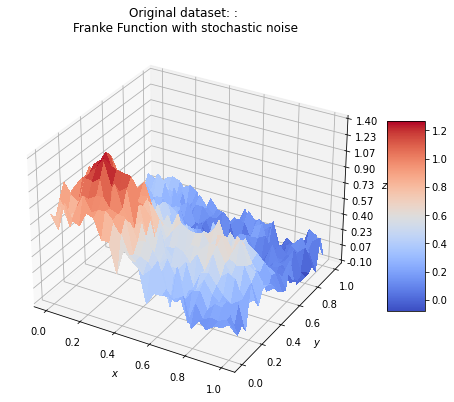

Performance with default values:
––––––––––––––––––––––––––––––––––––––––––––
OLS - MSE: 2.1815
OLS - R2: -25.0067
Ridge - MSE: 2.1815
Ridge - R2: -25.0067
OLS with SK - MSE: 0.0267
OLS with SK - R2: 0.6812
––––––––––––––––––––––––––––––––––––––––––––


In [2]:
# Degree of the polynomial
degree=5
# Datapoints (squared root of datapoints -> meshgrid)
n = 25
# Paramaters of noise distribution
mu_n = 0; sigma_n = 0.1

# Create vanilla dataset:
x,y,z = create_xyz_dataset(n,mu_n, sigma_n)
Plot_FrankeFunction(x,y,z, title="Original dataset: : \nFranke Function with stochastic noise")
# Convertion because of meshgrid
z = z.ravel(); n=n**2
X = create_X(x, y, degree)


n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches

# Default value
ols = OLSRegression(X,z)
ridge = RidgeRegression(X,z)
ols.split().rescale().fitSGD(n_epochs = n_epochs, M = M)
ridge.split().rescale().fitSGD(n_epochs = n_epochs, M = M)
print("Performance with default values:")
print("––––––––––––––––––––––––––––––––––––––––––––")
print("OLS - MSE:", ols.MSE_test())
print("OLS - R2:", ols.R2_test())
print("Ridge - MSE:", ols.MSE_test())
print("Ridge - R2:", ols.R2_test())
ols.fitSGD_SK()
print("OLS with SK - MSE:", ols.MSE_test())
print("OLS with SK - R2:", ols.R2_test())
print("––––––––––––––––––––––––––––––––––––––––––––")

No handles with labels found to put in legend.


Ridge: Best lambda value λ = 0.0001


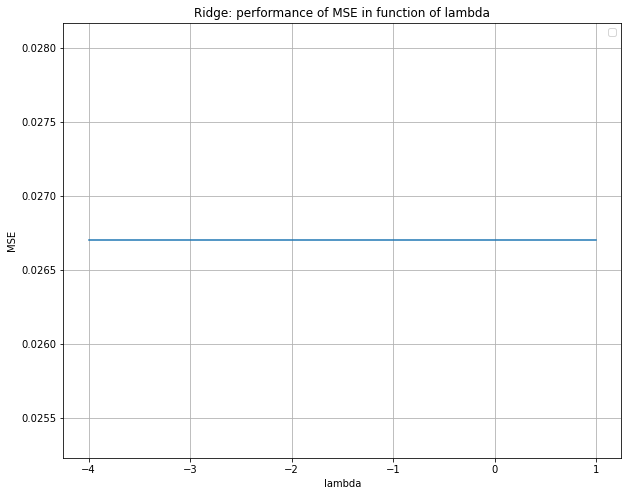

In [3]:
####### LAMBDA PERFORMANCE
nlambdas = 100
lambdas = np.logspace(-4, 1, nlambdas)
mse_ridge = np.zeros(nlambdas)

for i in range(nlambdas):
    ridge.set_lambda(lambdas[i])
    ridge.fitSGD(n_epochs = n_epochs, M = M)
    mse_ridge[i] = ols.MSE_test()

ind= find_min_indexes(mse_ridge)[0]
lmd=lambdas[ind]
ridge.set_lambda(lmd)
print("Ridge: Best lambda value λ = "+str(lmd))

fig = plt.figure(figsize=(10,8))
plt.plot(np.log10(lambdas),mse_ridge)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.title("Ridge: performance of MSE in function of lambda")
plt.grid(True)
plt.legend()
plt.show()

LEARNING RATE PERFORMANCE
OLS: Best learning rate η_0 = 1.00e-05 is given by t0 = 0.005 and t1 = 500
Ridge: Best learning rate η_0 = 5.00e-02 is given by t0 = 25 and t1 = 500
OLS with SK : Best learning rate η_0 = 4.17e-03 is given by t0 = 0.5 and t1 = 120


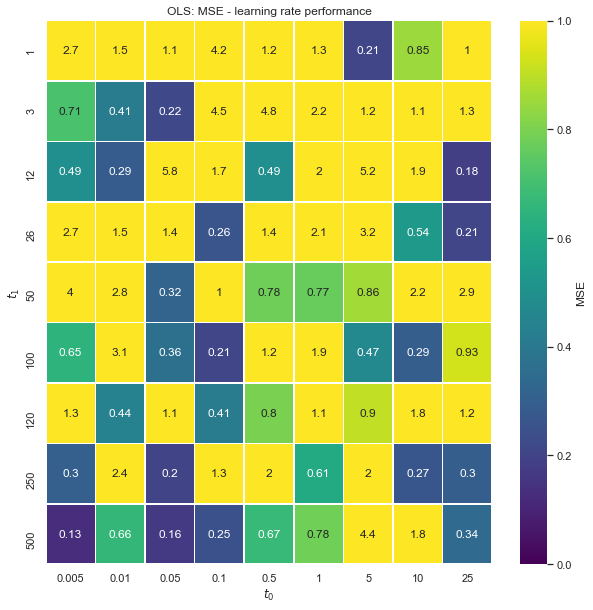

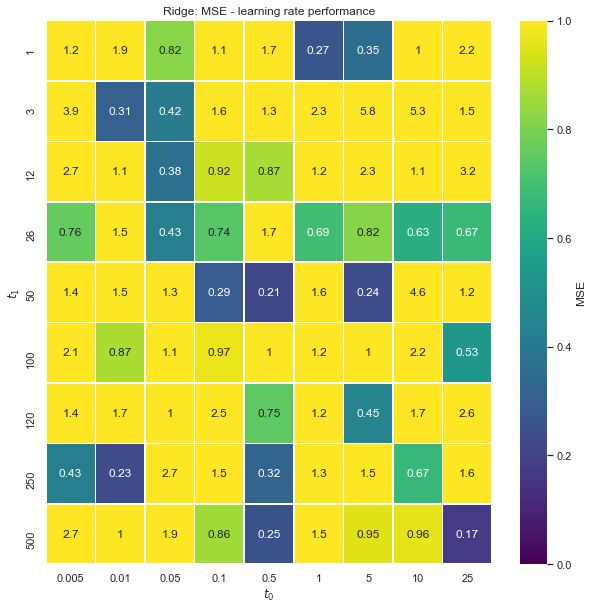

In [4]:
### LEARNING RATE
print("LEARNING RATE PERFORMANCE")

t0_vals = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25]
t1_vals = [1, 3, 12, 26, 50, 100, 120, 250, 500]

mse_ols = np.zeros((len(t0_vals), len(t1_vals)))
mse_ridge = np.zeros((len(t0_vals), len(t1_vals)))
mse_ols_sk = np.zeros((len(t0_vals), len(t1_vals)))

for i in range(len(t0_vals)):
    for j in range(len(t1_vals)):
        
        ols.fitSGD(n_epochs, M, eta_type ='schedule', t0=t0_vals[i], t1=t1_vals[j])
        ridge.fitSGD(n_epochs, M, eta_type ='schedule', t0=t0_vals[i], t1=t1_vals[j])
        
        mse_ols[i][j] = ols.MSE_test()
        mse_ridge[i][j] = ridge.MSE_test()
        
        ols.fitSGD_SK()
        mse_ols_sk[i][j] = ols.MSE_test()
        
        """
        if mse_ols[i][j] > 1.:
            mse_ols[i][j] = 1.
            
        if mse_ridge[i][j] > 1.:
            mse_ridge[i][j] = 1.
        """

import seaborn as sns

sns.set()

ind= find_min_indexes(mse_ols)
eta0_ols=t0_vals[ind[1]]/t1_vals[ind[0]]
t0_ols=t0_vals[ind[1]]
t1_ols=t1_vals[ind[0]]
print("OLS: Best learning rate \N{greek small letter eta}_0 = {:.2e}".format(eta0_ols)+" is given by t0 = "+str(t0_ols)+" and t1 = "+str(t1_ols))
ind= find_min_indexes(mse_ridge)
eta0_ridge=t0_vals[ind[1]]/t1_vals[ind[0]]
t0_ridge=t0_vals[ind[1]]
t1_ridge=t1_vals[ind[0]]
print("Ridge: Best learning rate \N{greek small letter eta}_0 = {:.2e}".format(eta0_ridge)+" is given by t0 = "+str(t0_ridge)+" and t1 = "+str(t1_ridge))
ind= find_min_indexes(mse_ols_sk)
print("OLS with SK : Best learning rate \N{greek small letter eta}_0 = {:.2e}".format(t0_vals[ind[1]]/t1_vals[ind[0]])+" is given by t0 = "+str(t0_vals[ind[1]])+" and t1 = "+str(t1_vals[ind[0]]))

 
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(mse_ols, annot=True, ax=ax, cmap="viridis", xticklabels=t0_vals, cbar_kws={'label': 'MSE'}, yticklabels=t1_vals, vmin=0, vmax=1, linewidths=.5)
ax.set_title("OLS: MSE - learning rate performance")
ax.set_ylabel("$t_1$")
ax.set_xlabel("$t_0$")
plt.savefig("Figures/SGD_eta_OLS.png", dpi =100)
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(mse_ridge, annot=True, ax=ax, cmap="viridis", xticklabels=t0_vals, cbar_kws={'label': 'MSE'}, yticklabels=t1_vals, vmin=0, vmax=1, linewidths=.5)
ax.set_title("Ridge: MSE - learning rate performance")
ax.set_ylabel("$t_1$")
ax.set_xlabel("$t_0$")
plt.savefig("Figures/SGD_eta_Ridge.png", dpi =100)
plt.show()

N_MINIBATCHES PERFORMANCE
OLS: Best number of mini-batches = 12
Ridge: Best number of mini-batches = 50
OLS with SK: Best number of mini-batches = 1


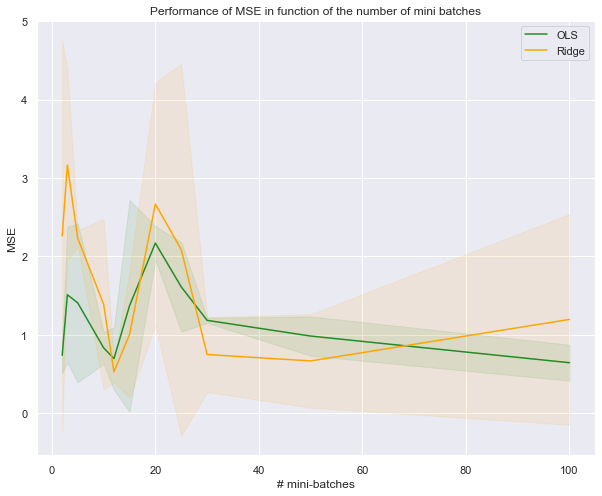

In [5]:
### N_MINIBATCHES
print("N_MINIBATCHES PERFORMANCE")

m_vals = [1, 2, 3, 5, 10, 12, 15, 20, 25, 30, 50, 100]

mse_ols = np.zeros((len(m_vals)))
mse_ridge = np.zeros((len(m_vals)))
mse_ols_sk = np.zeros((len(m_vals)))

for i in range(len(m_vals)):
        
    M = int(n/m_vals[i]) 
    ols.fitSGD(n_epochs, M, eta_type ='schedule', t0=t0_ols, t1=t1_ols) #ols.predictSGD_BS
    ridge.fitSGD(n_epochs, M, eta_type ='schedule', t0=t0_ridge, t1=t1_ridge) #ridge.predictSGD_BS

    mse_ols[i] = ols.MSE_test() #MSE_BS(y_pred_ols, ols.y_test) #
    mse_ridge[i] =  ridge.MSE_test() #MSE_BS(y_pred_ridge, ridge.y_test)
    
    #ols.predictSGD()
    #mse_ols_sk[i] = ols.MSE_test()

ind= find_min_indexes(mse_ols)[0]
m_ols = m_vals[ind]
print("OLS: Best number of mini-batches = "+str(m_ols))
ind= find_min_indexes(mse_ridge)[0]
m_ridge = m_vals[ind]
print("Ridge: Best number of mini-batches = "+str(m_ridge))
ind= find_min_indexes(mse_ols_sk)[0]
print("OLS with SK: Best number of mini-batches = "+str(m_vals[ind]))

        
fig = plt.figure(figsize=(10,8))
#Rolling Mean
y_rm, y_down, y_up = Rolling_Mean(mse_ols,2)
plt.plot(m_vals,y_rm, label="OLS", color="forestgreen")
plt.fill_between(m_vals, y_down, y_up, alpha=0.1, color="forestgreen")
y_rm, y_down, y_up = Rolling_Mean(mse_ridge,2)
plt.plot(m_vals,y_rm, label="Ridge", color="orange")
plt.fill_between(m_vals, y_down, y_up, alpha=0.1, color="orange")
plt.xlabel("# mini-batches")
plt.ylabel("MSE")
plt.title("Performance of MSE in function of the number of mini batches")
plt.grid(True)
plt.legend()
plt.savefig("Figures/SGD_minibatches.png", dpi =100)
plt.show()

N_EPOCHS PERFORMANCE
OLS: Best n_epochs = 150
Ridge: Best n_epochs = 150


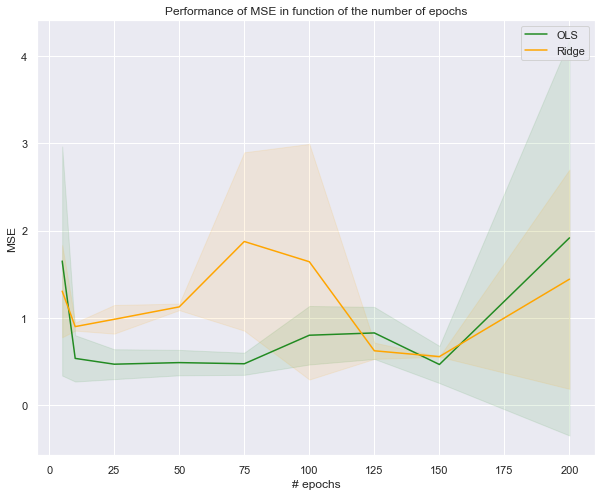

In [7]:
### N_EPOCHS
print("N_EPOCHS PERFORMANCE")

epochs_vals = [1, 5, 10, 25, 50, 75, 100, 125, 150, 200]

mse_ols = np.zeros((len(epochs_vals)))
mse_ridge = np.zeros((len(epochs_vals)))

for i in range(len(epochs_vals)):
        
    ols.fitSGD(epochs_vals[i], m_ols, eta_type ='schedule', t0=t0_ols, t1=t1_ols)
    ridge.fitSGD(epochs_vals[i], m_ridge, eta_type ='schedule', t0=t0_ridge, t1=t1_ridge)
    
    #y_pred_ols = ols.predictSGD_BS(epochs_vals[i], m_ols, eta_type ='schedule', t0=t0_ols, t1=t1_ols)
    #y_pred_ridge = ridge.predictSGD_BS(epochs_vals[i], m_ridge, eta_type ='schedule', t0=t0_ridge, t1=t1_ridge)

    mse_ols[i] = ols.MSE_test() #MSE_BS(y_pred_ols, ols.y_test) #
    mse_ridge[i] = ridge.MSE_test() #MSE_BS(y_pred_ridge, ridge.y_test) #

ind= find_min_indexes(mse_ols)[0]
n_epochs_ols = epochs_vals[ind]
print("OLS: Best n_epochs = "+str(n_epochs_ols))
ind= find_min_indexes(mse_ridge)[0]
n_epochs_ridge = epochs_vals[ind]
print("Ridge: Best n_epochs = "+str(n_epochs_ridge))
      
fig = plt.figure(figsize=(10,8))
y_rm, y_down, y_up = Rolling_Mean(mse_ols,2)
plt.plot(epochs_vals,y_rm, label="OLS", color="forestgreen")
plt.fill_between(epochs_vals, y_down, y_up, alpha=0.1, color="forestgreen")
y_rm, y_down, y_up = Rolling_Mean(mse_ridge,2)
plt.plot(epochs_vals,y_rm, label="Ridge", color="orange")
plt.fill_between(epochs_vals, y_down, y_up, alpha=0.1, color="orange")

#plt.plot(epochs_vals,mse_ols, label="OLS")
#plt.plot(epochs_vals,mse_ridge, label="Ridge")
plt.xlabel("# epochs")
plt.ylabel("MSE")
plt.title("Performance of MSE in function of the number of epochs")
plt.grid(True)
plt.legend()
plt.savefig("Figures/SGD_epochs.png", dpi =100)
plt.show()

In [ ]:
n_epochs_ridge = 150
m_ridge = 50

In [ ]:
### LAMBDA VS LEARNING RATE
print("LEARNING RATE PERFORMANCE")

eta0_vals = np.logspace(-5, 1, 12)
lambdas = np.logspace(-12, 1, 12)
eta_type ='static'

mse_ridge = np.zeros((len(lambdas), len(eta0_vals)))

for i in range(len(lambdas)):
    for j in range(len(eta0_vals)):
        ridge.set_lambda(lambdas[i])
        ridge.fitSGD(n_epochs_ridge, m_ridge, eta_type = eta_type, eta0 = eta0_vals[j])
        mse_ridge[i][j] = ridge.MSE_test()

Ridge: Best learning rate η_0 = 4.33e-04 and $\lambda$ = 1.87e-04


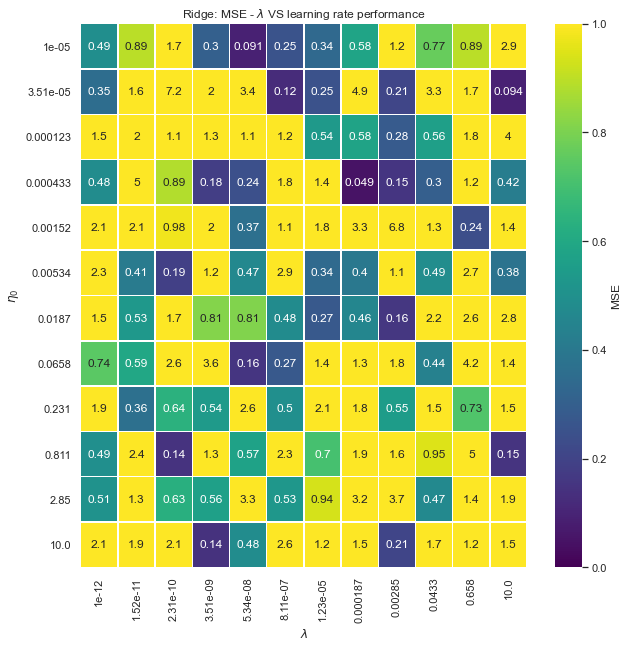

In [29]:
sns.set()

ind= find_min_indexes(mse_ridge)
lmd=lambdas[ind[1]]
eta0_ridge=eta0_vals[ind[0]]
print("Ridge: Best learning rate \N{greek small letter eta}_0 = {:.2e}".format(eta0_ridge)+" and $\lambda$ = {:.2e}".format(lmd))

fig, ax = plt.subplots(figsize = (10, 10))
lmbs = ['%s' % float('%.3g' % lmd) for lmd in lambdas]
ets = ['%s' % float('%.3g' % et) for et in eta0_vals]
sns.heatmap(mse_ridge, annot=True, ax=ax, cmap="viridis", xticklabels=lmbs, cbar_kws={'label': 'MSE'}, yticklabels=ets, vmin=0, vmax=1, linewidths=.5)
ax.set_title(r"Ridge: MSE - $\lambda$ VS learning rate performance")
ax.set_ylabel("$\eta_0$")
ax.set_xlabel("$\lambda$")
plt.savefig("Figures/SGD_lambda_eta.png", dpi =100)
plt.show()